In [61]:
%pip install wandb numpy tensorflow Pillow matplotlib keras


[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: C:\Users\kelle\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# Salamander Classification
This is a keras machine learning notebook for salamander classification

In [62]:
import wandb
wandb.init()

In [63]:
# This script needs these libraries to be installed:
#   tensorflow, numpy

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

import random
import numpy as np
import tensorflow as tf


# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="Salamander Classification",

    # track hyperparameters and run metadata with wandb.config
    config={
        "layer_1": 512,
        "activation_1": "relu",
        "dropout": random.uniform(0.01, 0.80),
        "layer_2": 10,
        "activation_2": "softmax",
        "optimizer": "sgd",
        "loss": "sparse_categorical_crossentropy",
        "metric": "accuracy",
        "epoch": 8,
        "batch_size": 256
    }
)



Start by importing useful libraries

In [64]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

After this, import the image data, assigning labels based on directory.

In [65]:
image_size = (180, 180)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "data",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 32 files belonging to 4 classes.
Using 26 files for training.
Using 6 files for validation.


Let's look at a few of the images to ensure they formatted properly.

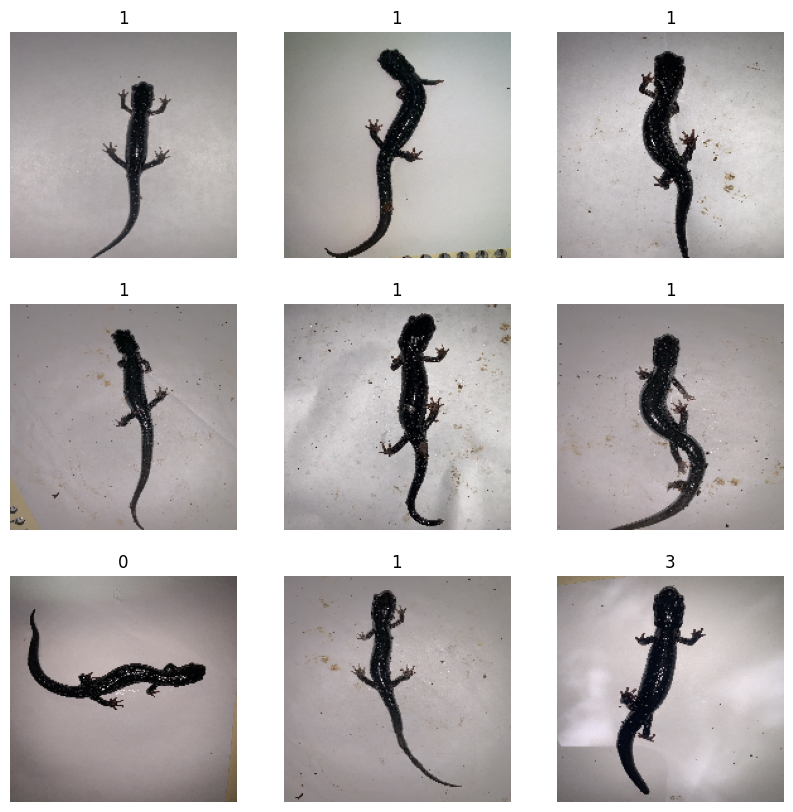

In [66]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Perfect. The number here represents the location the salamanders are from. Next, we introduce some random transformation (reflection, minor rotations, etc.). This prevents overfitting and also allows us to have more samples.

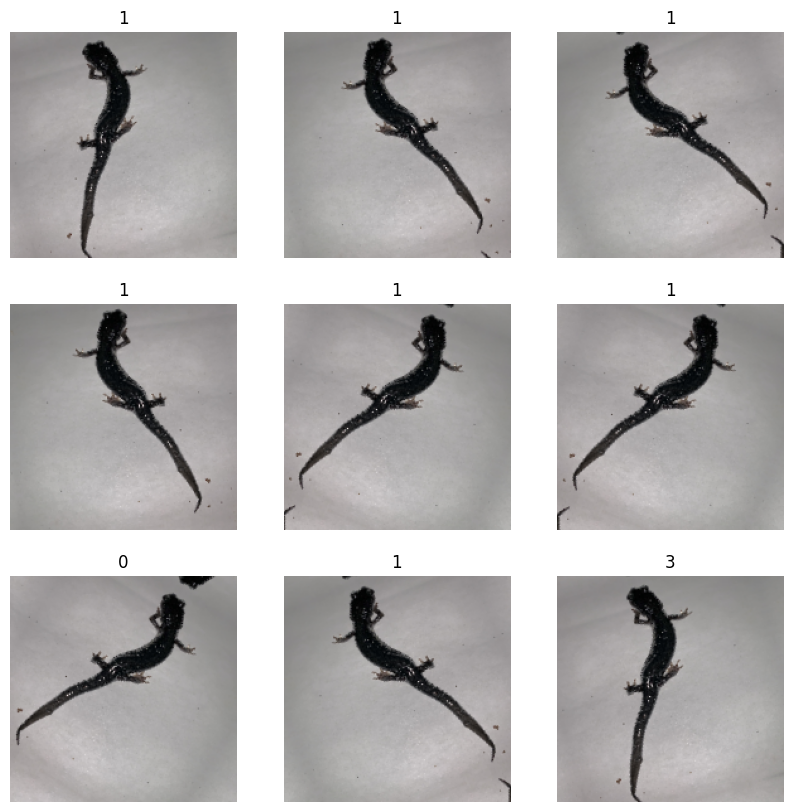

In [67]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

At this point, we need to integrate data_augmentation() and Rescaling (normalizes the RGB values). We do this before initializing the model, which utilizes the CPU over the GPU for the preprocessing.

In [68]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

Following this, we need to establish a model.

In [69]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


At this point, here's a useful image from the same keras.io documentation that explains what's happening.

Now, we train the dataset on our salamander images

In [73]:
epochs = 25

wandb.config.learning_rate = 0.01

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    WandbMetricsLogger()
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)


Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - acc: 0.5000 - loss: -10.9031 - val_acc: 0.3333 - val_loss: -0.3210
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - acc: 0.5769 - loss: -7.8771 - val_acc: 0.3333 - val_loss: -0.3552
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - acc: 0.5769 - loss: -10.4072 - val_acc: 0.3333 - val_loss: -0.3899
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - acc: 0.4231 - loss: -11.2435 - val_acc: 0.3333 - val_loss: -0.4144
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - acc: 0.5000 - loss: -10.7831 - val_acc: 0.3333 - val_loss: -0.4391
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - acc: 0.5385 - loss: -11.0273 - val_acc: 0.3333 - val_loss: -0.4630
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - acc: 0.5000 - loss: -11.6526 - val_acc: 0.3333 - val_loss: -0.4853
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - acc: 0.5000 - loss: -12.6131 - val_acc: 0.3333 - val_loss: -0.5031
Epoch 9/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - acc: 0.5000 - loss: -1

ValueError: You must pass an instance of wandb.Artifact or a valid file path to log_artifact

Unfortunately, accuracy was nearly 0. More data is needed.